In [1]:
from data_prep import *
from PositionModel import *
from PlayerModel import *
from commons import *
import shap
from sklearn.ensemble import RandomForestRegressor

In [2]:
features = ['goals_scored_avg5', 'xG_avg5', 'assists_fpl_avg5',
       'bonus_avg5', 'bps_avg5', 'clean_sheets_avg5', 'goals_conceded_avg5',
       'shots_avg5', 'xGBuildup_avg5', 'xGChain_avg5', 'yellow_cards_avg5',
       'red_cards_avg5', 'was_home', 'rating_diff']
rolling_columns = ['goals_scored', 'xG', 'assists_fpl', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'shots', 'xGBuildup', 'xGChain', 'yellow_cards', 'red_cards']
to_predict = 'total_points'

In [3]:
# loading dataset
# previous_games = merged_understat_and_fpl(rolling_columns, True)
previous_games = load_dataset()

In [4]:
# splitting data
X_train_def = previous_games[previous_games['position_fpl'] == 'DEF'][features]
y_train_def = previous_games[previous_games['position_fpl'] == 'DEF'][to_predict]

X_train_mid = previous_games[previous_games['position_fpl'] == 'MID'][features]
y_train_mid = previous_games[previous_games['position_fpl'] == 'MID'][to_predict]

X_train_fwd = previous_games[previous_games['position_fpl'] == 'FWD'][features]
y_train_fwd = previous_games[previous_games['position_fpl'] == 'FWD'][to_predict]

In [5]:
# general model fitting
position_model = PositionModel()

In [6]:
position_model.def_model.fit(X_train_def, y_train_def)
position_model.mid_model.fit(X_train_mid, y_train_mid)

RandomForestRegressor(random_state=42)

In [7]:
# getting next gameweek
next_gameweek = get_next_gameweek(previous_games, NEXT_GAMEWEEK, rolling_columns)

In [8]:
# removing NaNs
next_gameweek = next_gameweek.dropna(subset = features)

In [9]:
next_gameweek_gk = next_gameweek[next_gameweek['position_fpl'] == 'GK']
next_gameweek_def = next_gameweek[next_gameweek['position_fpl'] == 'DEF']
next_gameweek_mid = next_gameweek[next_gameweek['position_fpl'] == 'MID']
next_gameweek_fwd = next_gameweek[next_gameweek['position_fpl'] == 'FWD']

In [10]:
def get_shap_index_by_name(df, name):
    index = 0
    for i, r in df.iterrows():
        if r['name'] == name:
            return index
        index += 1
    return None

# DEFENDERS

In [11]:
# predicting
pred_points = position_model.def_model.predict(next_gameweek_def[features])

In [12]:
predictions = next_gameweek_def
predictions.insert(1, 'pred_points', pred_points)
predictions = predictions.sort_values(by = 'pred_points', ascending = False)

In [13]:
predictions[['name', 'was_home', 'opp_team_rating', 'pred_points']].head(20)

,name,was_home,opp_team_rating,pred_points
30,Reece James,0,1749.146973,6.72
80,Eric Dier,0,1872.177490,6.27
83,Ryan Sessegnon,0,1872.177490,6.04
57,Kieran Trippier,0,1661.436523,5.51
67,Fabian Schär,0,1661.436523,4.69
87,Virgil van Dijk,1,1779.396606,4.20
2,Cheikhou Kouyaté,1,1853.123535,4.14
55,Kyle Walker-Peters,1,1697.177124,3.47
85,Trent Alexander-Arnold,1,1779.396606,2.67
86,Joachim Andersen,1,1853.123535,2.23


In [14]:
# shap for predictions
explainer_pred = shap.Explainer(position_model.def_model, X_train_def)
shap_values_pred = explainer_pred(next_gameweek_def[features], check_additivity=False)

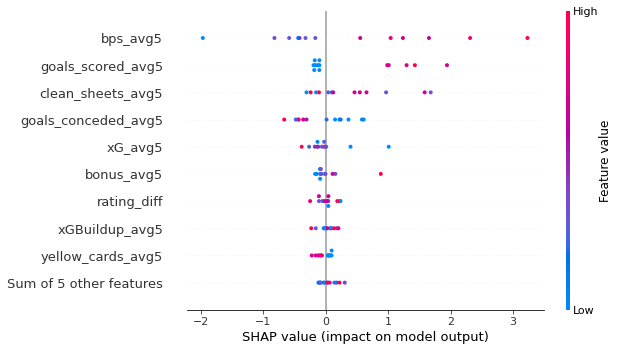

In [15]:
# feature influence
shap.plots.beeswarm(shap_values_pred)

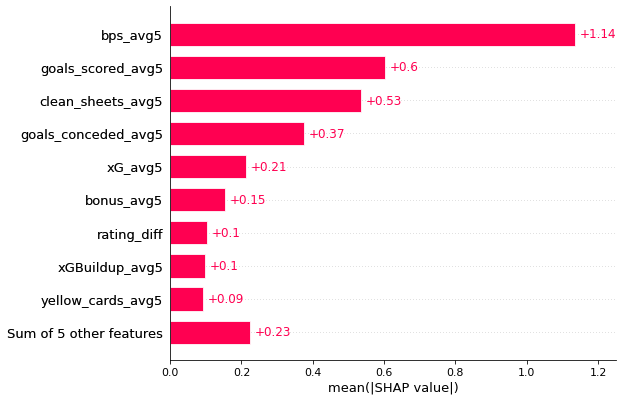

In [16]:
# feature importance
shap.plots.bar(shap_values_pred)

# MIDFIELDERS

In [17]:
# predicting
pred_points = position_model.mid_model.predict(next_gameweek_mid[features])

In [18]:
predictions = next_gameweek_mid
predictions.insert(1, 'pred_points', pred_points)
predictions = predictions.sort_values(by = 'pred_points', ascending = False)

In [19]:
predictions[['name', 'was_home', 'opp_team_rating', 'pred_points']].head(20)

,name,was_home,opp_team_rating,pred_points
51,James Maddison,1,1589.250000,10.04
72,Phil Foden,1,1806.040283,9.08
41,Christian Nørgaard,0,1638.479126,7.66
81,Pierre-Emile Højbjerg,0,1872.177490,7.57
82,Rodrigo Bentancur,0,1872.177490,7.38
54,Ilkay Gündogan,1,1806.040283,7.18
64,Kevin De Bruyne,1,1806.040283,6.40
79,Dejan Kulusevski,0,1872.177490,5.93
9,Harvey Barnes,1,1589.250000,5.85
35,Yoane Wissa,0,1638.479126,5.81


In [20]:
# shap for predictions
explainer_pred = shap.Explainer(position_model.mid_model, X_train_def)
shap_values_pred = explainer_pred(next_gameweek_mid[features], check_additivity=False)

In [21]:
# shap for previous games
explainer = shap.Explainer(position_model.mid_model, X_train_mid)
shap_values = explainer(X_train_def, check_additivity=False)

 99%|===================| 2023/2043 [00:38<00:00]        

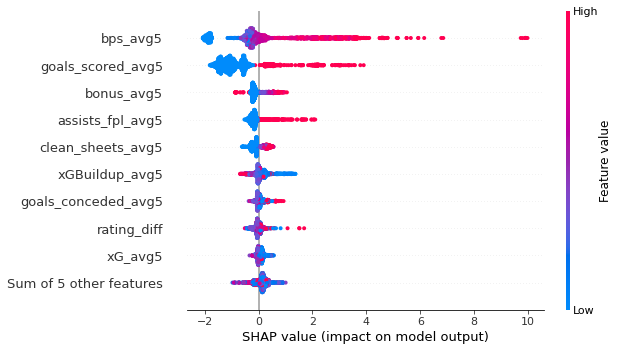

In [22]:
# feature influence
shap.plots.beeswarm(shap_values)

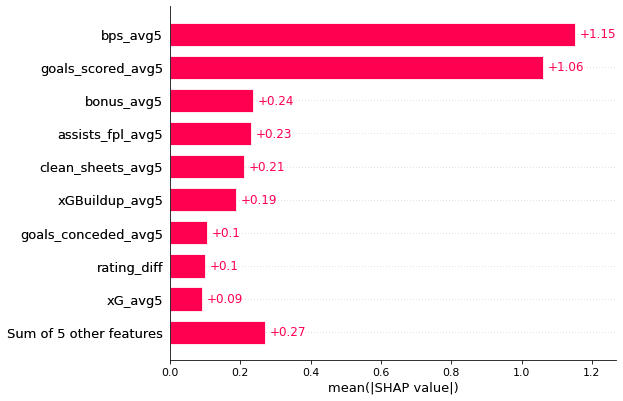

In [23]:
# feature importance
shap.plots.bar(shap_values)